# Image Captioning

## 0. Prérequis d'installation Python
Pour la dernière partie de ce notebook, le lecteur aura besoin d'un environnement virtuel sous Python 3.5.6. <br>
Aide éventuelle : 
- via conda : `conda create -n py35 python=3.5.6` (recommandé)
- via virtualenv : `virtualenv venv --python=python3.5`

Il lui faudra y installer les dépendances contenues dans 'requirements.txt' de la manière suivante (indépendente du type d'environnement)
`pip install -r requirements.txt`

## 1. Introduction

Un programme informatique qui permettrait de décrire précisément et quasi instantanément le contenu d'une image par des phrases ? C'est ce qu'annonce le New York Times en novembre 2014 ([Researchers Announce Advance in Image-Recognition Software](https://www.nytimes.com/2014/11/18/science/researchers-announce-breakthrough-in-content-recognition-software.html)). <br>
Dans cet article de presse sont présentés deux projets qui ont abouti presque simultanément à des outils présentant les caractéristiques décrites ci-dessus : ce notebook traite du domaine de recherche qui est apparu avec la publication de ces projets : l'***Image Captioning***. <br>
Le premier de ces projets (temporellement parlant), [Show and Tell: A Neural Image Caption Generator](https://arxiv.org/abs/1411.4555) (NIC), a été soumis en Novembre 2014 par O. Vinyals, A. Toshev, S. Bengio et D. Erhan, tous quatre chercheurs chez Google. Moins d'un mois après, A. Karpathy et L. Fei-Fei (Stanford University) soumettent [Deep Visual-Semantic Alignments for Generating Image Descriptions](https://arxiv.org/abs/1412.2306) ; la courte durée séparant les deux publications marque le fait que les deux travaux sont entièrement indépendants, même si le deuxième cite brièvement le premier.
Dans ce notebook, nous allons principalement présenter les travaux de Karpathy et al, tout en gardant ceux de Vinyals et al comme points de comparaison réguliers.

Outre une grande avancée dans le domaine de la recherche fondamentale, il est aisé de trouver de nombreuses applications à l'*Image Captioning*.
- Les voitures autonomes (ou plus largement les robots autonomes, de sauvetage par exemple) pourraient utiliser de tels programmes pour une meilleure appréhension de l'environnement extérieur et en particulier du comportement des piétons alentours.
- Une autre application particulièrement honorable est celle du guidage en temps réel de personnes malvoyantes, en utilisant le programme en question comme un outil d'audio-description en direct.
- Le référencement de vidéos ou d'images, toujours plus nombreuses sur internet, pourrait être grandement amélioré sans intervention humaine grâce à cette technologie.
- D'autres applications plus controversées comme la vidéo-surveillance pourraient également faire usage de cette technologie : les caméras pourraient ainsi par exemple prévenir de manière autonome la police d'événements potentiellement frauduleux ou criminels.

En 2014, les efforts de la recherche en *Computer Vision* sont en grande partie concentrés sur la classification d'images et la reconnaissance d'objets. Le *Captioning* est bien plus ambitieux car outre la reconnaissance et l'identification d'objets sur une image, il vise -au détriment potentiel d'une certaine précision- à décrire la relation entre ces différents objets, qui plus est par l'usage de langage naturel. <br>
C'est par cette dernière spécificité que ce projet se situe à mi-chemin entre le domaine de la *Computer Vision* et celui du *Natural Language Processing* (en l'occurence la génération de texte). <br>
Quelques autres équipes de recherche se sont par le passé penchées sur ce type de problème, aboutissant à des résultats intéressants, mais caractérisés par une précision relativement faible, une capacité de généralisation peu satisfaisante et trop peu de flexibilité quand à la structure des phrases générées.

L'élément clé différenciant nos deux articles de ces travaux précédents réside dans l'utilisation combinée de *Convolutional Neural Networks* profonds (CNN) pour l'interprétation de l'image et de *Reccurent Neural Networks* (RNN) pour la génération de phrases.

## 1.1 Note sur le cadre de ce notebook
Avant de se lancer dans la présentation des travaux, on notera que l'article au centre de ce notebook, Deep Visual-Semantic Alignments for Generating Image Descriptions (Stanford University), présente en réalité deux algorithmes : l'un, comme annoncé dans l'introduction, génère des phrases décrivant l'image reçue en entrée. Pour un souci de temps de lecture du notebook limité, c'est sur cette partie de l'article que nous allons nous focaliser dans ce notebook. L'autre partie de l'article, que nous nous devons tout de même d'évoquer, est toute aussi intéressante en proposant un algorithme qui décrit les différents centres d'intérêt de l'image avec quelques mots. La différence entre ces deux algorithmes issus de la même publication est illustrée ci-dessous (images issues de l'article). <br>

Nous avons choisi de traiter en précision la première partie sur la génération de phrases car le fait de pouvoir comparer cet algorithme avec celui publié par l'équipe de Google, relativement proche mais produit de manière entièrement décorrélée, nous semblait une opportunité rare et intéressante.

<center>
    <figure>
        <img src="figures/neuraltalk1.PNG" width="800"
             alt="neuraltalk1">
        <center>
            <figcaption>Génération de descripteurs par zones d'intérêt (algorithme écarté dans ce notebook)</figcaption>
        </center>
    </figure>
</center>
<center>
    <figure>
        <img src="figures/neuraltalk2.PNG" width="800"
             alt="neuraltalk2">
        <center>
            <figcaption>Génération de phrases décrivant l'image d'entrée (algorithme présenté dans ce notebook)</figcaption>
        </center>
    </figure>
</center>



## 2. Présentation théorique des travaux

L'équipe de Google propose une vision intéressante du problème de *Captioning* comme un problème de traduction automatique : ici le langage source est une image et le langage de destination est l'anglais naturel. Une solution à la traduction automatique est l'utilisation de RNN comme encodeur puis comme décodeur ; dans ce cas précis, on préfère utiliser un CNN comme encodeur, plus adapté à l'analyse d'images. <br>
Ainsi, l'information suit le parcours suivant pour la génération de texte une fois l'algorithme entraîné: 
- L'image d'entrée, sous forme de matrice de pixels, traverse le CNN pour donner une représentation vectorielle correspondant à un encodage de cette image. 
- Cette représentation vectorielle est ensuite envoyée au RNN décodeur qui va ainsi générer une phrase correspondant à l'image.

Ce "trajet" est valable autant pour l'algorithme de l'équipe de Stanford que pour celui de l'équipe de Google, les structures des algorithmes étant relativement proches : les différences majeures entre les deux projets résideront plutôt dans les architectures des modèles de RNN et CNN utilisés.

Nous allons ci-dessous présenter plus en détail le fonctionnement du *Recurrent Neural Network* et du *Convolutional Neural Network* dans ce contexte précis d'*Image Captioning*.

### 2.1 Génération de phrases à partir de Recurrent Neural Networks

#### 2.1.1 Les RNN

Les RNN sont particulièrement propices au traitement de données séquentielles : depuis la publication [Generating Text with Recurrent Neural Networks](https://icml.cc/Conferences/2011/papers/524_icmlpaper.pdf) en 2011, cet outil est largement utilisé dans de nombreuses tâches de *Natural Language Processing*.

Nous rappelons ci-dessous le fonctionnement d'un RNN basique dans le cadre de la génération de texte.
Le principe général est de générer, mot par mot, une distribution de probabilité sur le prochain mot en connaissant les mots précédents.

Le raisonnement générique est le suivant :
<center>
    <figure>
        <img src="figures/Capture_catsatonmat.PNG" width="400"
             alt="RNN simple example">
        <figcaption>Exemple de phrase simple générée par un RNN</figcaption>
    </figure>
</center>

***

&ensp;while $x_t\neq\text{<END>}$:<br>
&ensp;&ensp;&ensp; $h_t = f\left( W_{hx} *x_t + W_{hh} * h_{t-1}\right)$ <br>
&ensp;&ensp;&ensp; $y_t = \text{softmax}\left( W_{oh} * h_t \right)$ <br>
&ensp;&ensp;&ensp; sample $x_{t+1}$ from $y_t$ <br>
&ensp;&ensp;&ensp; $t\leftarrow t+1$ 

***

Dans le pseudo-algorithme ci-dessus, $f$ est une fonction d'activation (ici ReLU) et $W_{hx}$ , $W_{hh}$ , $W_{oh}$ sont des poids apprenables (on notera que ces poids sont constants et indépendants de $t$). <br>
Les $y_t$ sont des vecteurs contenant la log-probabilité de chaque mot du dictionnaire, conditionnellement au contexte. En pratique : $y_t[i]=\mathbb{P}(\text{vocab}[i] ~\vert~ \text{mots précédents})$   
Les $x_t$ sont des vecteurs de dimension 300 ; le passage d'un $x_t$ au mot correspondant  (et vice-versa) s'effectue avec des outils de vectorisation de mots comme [word2vec](https://arxiv.org/abs/1310.4546), grâce auxquels deux mots au sens proche seront représentés par des vecteurs peu distants.


#### 2.1.2 Comment prendre en compte une image pour générer du texte ?

Dans le cadre du *Captioning* de Karpathy et al, on rajoute dans le calcul de $h_0$ (pseudo-algorithme ci-dessus) le terme $W_{hi}*\text{CNN}(\text{image})$. C'est grâce à cet ajout que la phrase générée par le RNN prendra en compte le contenu de l'image. L'obtention de $\text{CNN}(\text{image})$ est documentée dans la partie suivante (2.2 Traitement d'images par CNN).

#### 2.1.3 Entrainement du RNN

Pendant l'entraînement, on présente au RNN des couples (image, label) où les labels seront des phrases (5 phrases par image) : plusieurs datasets de ce type existent, les plus connus étant Flickr8k (8000 couples), Flickr30k (30000 couples) et MS-COCO (123000 couples). 
L'entrainement consiste en l'exécution successive d'opérations de rétropropagation pour optimiser les différents poids du réseau en parcourant le dataset, avec pour objectif que le $t$ème mot du label ait une probabilité maximale d'être "samplé" dans $y_{t-1}$.


### 2.2 Traitement d'images par CNN

Depuis 2012 avec la publication [ImageNet Classification with Deep Convolutional
Neural Networks](https://papers.nips.cc/paper/2012/file/c399862d3b9d6b76c8436e924a68c45b-Paper.pdf), aujourd'hui citée plus de 77000 fois, les réseaux de neurones convolutifs profonds (ou CNN) sont massivement utilisés dans le cadre du traitement d'images : nous ne détaillerons pas leur fonctionnement ici car il est supposé connu par le lecteur. 

Dans le cadre du *Captioning*, il est nécessaire d'appliquer un CNN à l'image à décrire, afin d'en extraire les composantes visuelles principales et d'y reconnaître des patterns permettant l'interprétation de l'image par la machine.
Karpathy et Fei-Fei ont décidé d'utiliser le CNN "VGG-16" ([Very Deep Convolutional Networks for Large-Scale Image Recognition
](https://arxiv.org/abs/1409.1556)) de par son implémentation publique et sa notoriété. Ce réseau à 16 couches visualisable ci-dessous est destiné en grande partie à la classification d'images, et des versions pré-entrainées sur de gros jeux de données d'images (le très reconnu [imagenet](http://www.image-net.org/) par exemple) sont disponibles en accès libre. <br>
On notera que le choix de VGG16 n'est en aucun cas la seule solution possible : l'équipe de Google a quant à elle privilégié la puissance du CNN en choisissant [GoogLeNet](https://arxiv.org/pdf/1409.4842.pdf) ; dans notre implémentation disponible plus bas dans ce notebook, nous utilisons [Inceptionv3](https://arxiv.org/pdf/1512.00567v3.pdf) qui est une amélioration de GoogLeNet.

<center>
    <figure>
        <img src="figures/VGG16.png" width="800"
             alt="VGG16">
        <center>
            <figcaption>Schéma du CNN VGG16</figcaption>
        </center>
    </figure>
</center>

VGG16 étant un réseau de neurones convolutionnel dédié à la classification d'images, ses sorties sont de taille 1000 ; la couche de sortie (fc8 sur l'image ci-dessus) représente donc la probabilité que l'image d'entrée appartienne à chacune des 1000 classes disponibles. <br>
Le projet de *Captioning* ne visant pas exactement à la classification d'images, utiliser les sorties du VGG16 telles quelles n'aurait pas vraiment de sens : l'équipe de Stanford a donc fait le choix d'injecter dans le RNN décrit plus haut les sorties de la dernière couche cachée du réseau VGG16 (donc fc7 au lieu de fc8 sur l'image ci-dessus). Ainsi, l'output récupéré, de dimension 4096, sera une bonne représentation latente (représentation vectorielle abstraite faisant preuve d'une grande explicabilité des données) de l'image d'entrée et permettra d'extraire les différents features de cette image. 

Pour entraîner un CNN comme VGG16, il "suffit" d'effectuer une boucle sur les quatre actions suivantes : 1. Sampler des données, 2. Les faire traverser le réseau, 3. Rétropropager les erreurs et 4. Mettre à jour les poids.

En résumé, VGG16, une fois entraîné sur le dataset imagenet évoqué plus haut, fonctionne comme un encodeur de l'image à décrire ; l'image ainsi encodée va donc être injectée dans le RNN décrit dans la partie précédente (dont vous connaissez désormais le fonctionnement) afin d'obtenir une description textuelle de cette image.


## 3. Améliorations de l'algorithme

### 3.1 Type de RNN
Il est possible d'atteindre de bien meilleures performances en utilisant des réseaux différents de celui, très basique, décrit ci-dessus. En particulier, les LSTM ([Long Short-Term Memory](https://dl.acm.org/doi/10.1162/neco.1997.9.8.1735)) sont très utilisés dans ce domaine et notamment par *Neural Image Caption* (nom de l'algorithme développé par l'équipe de Google). Notre implémentation (voir section pratique ci-après) utilise également des LSTM. Par un souci de temps d'exécution du notebook, nous ne détaillerons pas le fonctionnement de ces outils (de plus, le lecteur a normalement déjà rencontré ce type de réseaux en cours de Machine Learning).
Si les LSTM donnent des meilleurs résultats que les RNN classiques, ils sont toutefois bien plus longs à entraîner.

### 3.2 Datasets
Dans la partie pratique ci-après, nous avons entraîné notre algorithme sur le dataset Flickr8k pour des raisons de capacités de calcul ; opter pour un dataset plus volumineux comme Flickr30k ou encore MSCOCO améliorerait très certainement les résultats, au moins en terme de vocabulaire et de capacité de généralisation. L'entraînement des modèles, déjà très long (plusieurs heures voire dizaines d'heures selon la machine) se verrait toutefois naturellement rallongé.

<center>
    <figure>
        <img src="figures/mscoco_flickr.png" width="600"
             alt="datasets">
        <center>
            <figcaption>Statistiques sur les différents datasets d'Image Captioning <a href=">https://www.researchgate.net/publication/328948763_Sequential_Dual_Attention_Coarse-to-Fine-Grained_Hierarchical_Generation_for_Image_Captioning">(Guan et al, 2018)</a></figcaption>
        </center>
    </figure>
</center>

### 3.3 Attention
Un pas en avant notable dans le domaine de l'*image captioning* a été observé avec l'utilisation de modèles d'attention : ainsi, [Show, Attend and Tell: Neural Image Caption
Generation with Visual Attention](http://proceedings.mlr.press/v37/xuc15.pdf) (dérivé de [Show and Tell: A Neural Image Caption Generator](https://arxiv.org/abs/1411.4555)) propose une approche donnant des résultats qui battent largement les précédents modèles d'*image captioning*.
En bref, l'attention consiste à diriger la concentration des réseaux de neurones vers une zone d'intérêt de l'image (voir illustration ci-dessous) : cela permet de décomposer l'analyse d'une image complexe en plusieurs analyses plus simples. (bien sûr, l'attention en deep learning ne se limite pas au domaine du *Computer Vision* : elle a permis ces dernières années d'améliorer de nombreux modèles dans des domaines variés)
<center>
    <figure>
        <img src="figures/attention.png" 
             alt="attention">
        <center>
            <figcaption>Illustration du concept d'attention en Computer Vision: l'algorithme apprend à se focaliser sur les mots importants de la phrase ou les zones importantes de l'image (d'après Show, Attend and Tell: Neural Image Caption
Generation with Visual Attention)</figcaption>
        </center>
    </figure>
</center>

### 3.4 Beam Search
Depuis la publication des articles traités ici, d'autres améliorations ont été faites : on notera par exemple le Beam Search (recherche par faisceau), consistant à trier les mots probables au cours de la génération en se basant sur une heuristique. Cette méthode s'est avérée très efficace quant à la qualité des phrases générées.

### 3.5 Intégration de l'image dans le RNN
Une autre piste de réflexion intéressante est celle du lien entre la partie traitement d'image (CNN) et la partie génération de phrases (RNN) : en effet, là où Karpathy et al ont décidé d'injecter le résultat du CNN dans le RNN sous forme d'un biais à la première itération sur $t$, Vinyals et al préfèrent l'incorporer directement en tant que premier mot. Quant à notre implémentation ci-dessous, elle réinjecte cette représentation vectorielle de l'image à chaque itération en tant que contexte. Cette question sur la manière d'intégrer les informations de l'image reste relativement ouverte, bien que traitée dans [Different ways of conditioning a neural language model with an image](https://arxiv.org/pdf/1703.09137.pdf).

## 4. Mise en pratique

Le code correspondant au papier de Stanford était censé être publié en accès libre sous [github.com/karpathy/neuraltalk](https://github.com/karpathy/neuraltalk) : malheureusement, celui-ci est difficilement manipulable (il n'utilise aucune bibliothèque de Machine Learning !), est peu documenté et comporte des erreurs à l'exécution ; de plus, une fois débuggé et entraîné (plus de 24h), les résultats restent très mauvais, sûrement à cause d'erreurs non relevées dans le script. <br>
C'est pourquoi j'ai réimplémenté cet algorithme, en me basant sur l'implémentation de Karpathy (NeuralTalk) et sur celle de [github.com/yashk2810/Image-Captioning](https://github.com/yashk2810/Image-Captioning). <br>
Cette nouvelle implémentation diffère donc en quelques points des techniques décrites plus haut, qui avaient pour objectif une compréhension optimale du lecteur en un temps très limité, alors que le code ci-dessous privilégie plutôt la qualité des résultats et le temps d'entrainement sur mon ordinateur. Les explications de la partie théorique restent évidemment valables pour la compréhension de ce qui va suivre en termes de raisonnement, cette partie pratique ayant essentiellement pour but d'illustrer les résultats obtenables.

In [7]:
# Importations
from keras.models import Sequential, Model
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector, Activation, Flatten, Dense, Merge
from keras.layers.wrappers import Bidirectional
from keras.preprocessing import sequence, image
from PIL import Image
import numpy as np
from IPython.display import SVG
from keras.utils.visualize_util import model_to_dot

In [8]:
# Pour ne pas surcharger le notebook, les réseaux ont été pré-entraînés et sont 
# récupérés, avec les variables nécessaires, via la fonction compute_all, disponible dans le fichier script.py
from script import compute_all
image_files = 'data/flickr8k/test_images/'
dict_params = compute_all(image_files)

In [9]:
# Définition de deux sous-réseaux : l'un (image_model) faisant le lien avec la sortie du CNN
# et l'autre (caption_model) qui est responsable de la génération de phrases
# On notera que la taille de l'entrée de image_model est 2048 et non 4096 car nous avons utilisé un CNN différent de VGG16
# L'entrée de caption_model est quant à elle de taille 40 car c'est la longueur de phrase maximale que l'on a choisi
image_model = Sequential([
        Dense(dict_params['embedding_size'], input_shape=(2048,), activation='relu', name='image_dense'),
        RepeatVector(dict_params['max_len'], name='image_repeat')
    ], name="image_model")
caption_model = Sequential([
        Embedding(dict_params['vocab_size'], dict_params['embedding_size'], input_length=dict_params['max_len'], name='caption_embedding'),
        LSTM(256, return_sequences=True, name='caption_lstm'),
        TimeDistributed(Dense(300),name='caption_timedense')
    ], name="caption_model")

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
image_dense (Dense)              (None, 300)           614700      dense_input_2[0][0]              
____________________________________________________________________________________________________
image_repeat (RepeatVector)      (None, 40, 300)       0           image_dense[0][0]                
____________________________________________________________________________________________________
caption_embedding (Embedding)    (None, 40, 300)       2476800     embedding_input_2[0][0]          
____________________________________________________________________________________________________
caption_lstm (LSTM)              (None, 40, 256)       570368      caption_embedding[0][0]          
___________________________________________________________________________________________

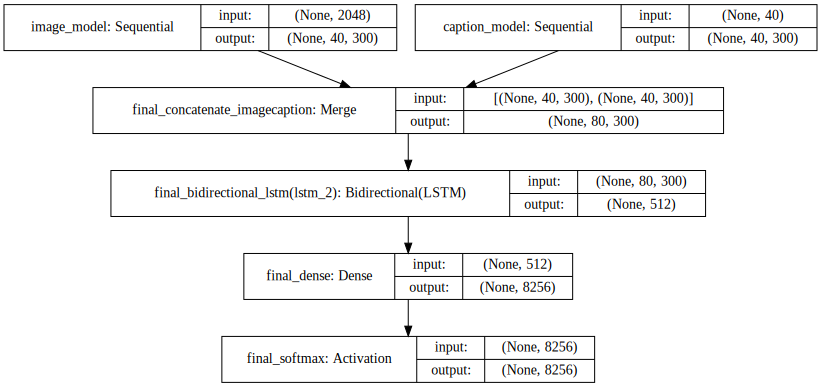

In [10]:
# Fusion des deux sous-réseaux et utilisation d'un softmax pour obtenir une 
# distribution de probabilités sur le prochain mot
final_model = Sequential([
        Merge([image_model, caption_model], mode='concat', concat_axis=1, name='final_concatenate_imagecaption'),
        Bidirectional(LSTM(256, return_sequences=False), name='final_bidirectional_lstm'),
        Dense(dict_params['vocab_size'], name='final_dense'),
        Activation('softmax',name='final_softmax')
    ])
# Chargement d'un réseau pré-enregistré (l'entraînement de ce réseau à 9 millions
# de paramètres serait beaucoup trop long à effectuer pour ce notebook)
final_model.load_weights('cv/time_inceptionV3_1.5987_loss.h5')
final_model.summary()
# Visualisation du réseau
SVG(model_to_dot(final_model,show_shapes=True,show_layer_names=True).create(prog='dot', format='svg'))

In [11]:
def predict_captions(image):
    caption_words = ["<start>"]
    while True: # Pour la génération de chaque mot, on fait appel au RNN
        # Préparation du contexte (mots déjà générés pour l'instant)
        par_caps = [dict_params['word2idx'][i] for i in caption_words]
        # pad_sequences ajoute des éléments neutres à la fin de la liste pour fournir au réseau un input de taille fixe (40)
        par_caps = sequence.pad_sequences([par_caps], maxlen=dict_params['max_len'], padding='post')
        # Prise en compte de l'image à chaque pas de temps
        e = dict_params['encoded_test_img'][image[len(image_files):]]
        # Traversée du réseau
        preds = final_model.predict([np.array([e]), np.array(par_caps)])
        # Choix du prochain mot : celui qui possède la probabilité la plus haute (version déterministe de l'algorithme)
        word_pred = dict_params['idx2word'][np.argmax(preds[0])]
        caption_words.append(word_pred)
        
        # Fin de la phrase
        if word_pred == "<end>" or len(caption_words) > dict_params['max_len']:
            break            
    return ' '.join(caption_words[1:-1])

Lancez quelques fois la cellule ci-dessous, pour juger par vous-même des résultats ... Certains sont précisément exacts, beaucoup sont cohérents avec quelques erreurs éventuelles, et quelques uns sont médiocres : nous détaillons les différents types d'erreur plus bas en fixant la valeur de idx. 

Generated caption for this image from the testing dataset:
A white dog is jumping in some water on a sidewalk .

Ground-truth labels for this image:
  -  A dog corners a little girl next to a police cruiser .
  -  A girl playing with a dog near a police car .
  -  A large white dog , a girl , and a police car in a driveway and an SUV in a garage .
  -  A little girl is playing with a large , white poodle in the driveway next to a police car .
  -  The girl is playing with her dog in her driveway .



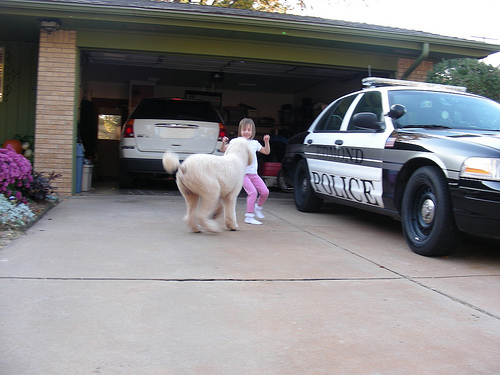

In [12]:
idx = np.random.randint(0, len(dict_params['test_img'])) # choix d'une image aléatoire dans 
    # le dataset de test (donc jamais rencontrée par l'algorithme au cours du training)
im = dict_params['test_img'][idx] # adresse de l'image à décrire
print ('Generated caption for this image from the testing dataset:')
print(predict_captions(im))
print('\nGround-truth labels for this image:') # labels que l'on aurait donné à notre 
    # algorithme si cette image avait été dans le dataset d'entrainement
for sentence in dict_params['test_captions'][im]:
    print('  - ',sentence)
print()
Image.open(im)

Vous pouvez également fixer la valeur de idx à une des valeurs suivantes, pour visualiser quelques inconvénients de cette méthode de *captioning* :
- 834 : la description fonctionne parfaitement
- 625 : la description n'a aucun rapport avec l'image excepté le mot "line", de plus, la phrase n'est pas grammaticalement correcte ; cela montre que l'algorithme est loin d'être infaillible 
- 368 : la description est cohérente à l'exception du chiffre proposé: c'est là l'un des inconvénients de la vectorisation des mots. En effet, deux mots proches sémantiquement, comme les différents chiffres par exemple, auront tendance à être encodés par des vecteurs très semblables. Cela implique qu'ils seront plus facilement "mélangés" par le réseau de neurones lors de l'attribution des probabilités dans la toute dernière couche. 
- 273 : outre la description peu cohérente, on trouve dans ce cas comme dans beaucoup d'autres dans le dataset, l'évocation d'une couleur qui n'est nulle part présente dans l'image. Cela est sûrement lié au problème présenté dans le point précédent : les différentes couleurs ayant un encodage très proche, elles sont très susceptibles d'être échangées lors de la génération de texte.
- 802 : bien sûr, un autre problème, commun à la grande majorité des méthodes actuelles, peut survenir fréquemment : on peut facilement supposer que le dataset d'entraînement contenait peu voire pas de coiffes d'indien ou encore de flutes de Pan. Dans ce cas, il est bien sûr impossible pour l'algorithme d'inventer ces termes, et tout aussi peu probable de deviner qu'il s'agit d'instruments de musique. Nous faisons donc face ici à un problème de généralisation dû à une trop grande différence de l'image de test avec le dataset d'entraînement. (on remarquera que la prédiction "accordéon" semble étonnament réaliste avec la position de la main de l'artiste ainsi que sa veste ressemblant beaucoup à cet instrument)  

### En bonus 
Le vidéaste Kyle McDonald s'est amusé à se promener dans les rues d'Amsterdam avec la webcam de son ordinateur reliée au générateur de *captions* (entraîné) de Karpathy et al. Le générateur fournit donc des descriptions textuelles à une certaine fréquence en analysant les *frames* en direct. 
Cette vidéo est disponible dans la cellule suivante (ou sur vimeo : [NeuralTalk and Walk](https://vimeo.com/146492001)). <br>
Les résultats produits sont intéressants bien qu'évidemment assez approximatifs, mais laissent présager de beaux jours à ce type de technologie, en particulier dans le cadre du guidage de personnes aveugles (pour lesquelles l'application de K. McDonald est directement adaptable).


In [13]:
from IPython.display import HTML

HTML('<center><iframe src="https://player.vimeo.com/video/146492001?title=0&byline=0&portrait=0" width="700" height="394" align="center" frameborder="0" webkitallowfullscreen mozallowfullscreen allowfullscreen></iframe></center>')
